[I 2025-04-11 15:09:31,399] A new study created in memory with name: no-name-1c8128cf-d8d4-480c-9d5d-4a7cf36991a6
[I 2025-04-11 15:09:34,662] Trial 0 finished with value: 0.8938053097345132 and parameters: {'dropout_rate': 0.380384547578285, 'learning_rate': 0.00040600123911510095, 'batch_size': 32, 'l1_lambda': 0.0033284178992766043}. Best is trial 0 with value: 0.8938053097345132.
[I 2025-04-11 15:09:35,358] Trial 1 finished with value: 0.911504424778761 and parameters: {'dropout_rate': 0.2503329888445805, 'learning_rate': 0.0011434340555203895, 'batch_size': 64, 'l1_lambda': 0.00038030331728483856}. Best is trial 1 with value: 0.911504424778761.
[I 2025-04-11 15:09:36,009] Trial 2 finished with value: 0.911504424778761 and parameters: {'dropout_rate': 0.37330359869483565, 'learning_rate': 0.006418137134159202, 'batch_size': 64, 'l1_lambda': 0.0014555205401017462}. Best is trial 1 with value: 0.911504424778761.
[I 2025-04-11 15:09:36,673] Trial 3 finished with value: 0.86725663716814

Best Hyperparameters: {'dropout_rate': 0.11087312210546679, 'learning_rate': 0.001934523806367816, 'batch_size': 32, 'l1_lambda': 0.00010926036765361356}

=== 🚀 Training Performance ===
Training Accuracy: 0.9349

Training Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90        54
           1       0.94      0.91      0.92        54
           2       0.93      0.97      0.95       153

    accuracy                           0.93       261
   macro avg       0.94      0.92      0.93       261
weighted avg       0.94      0.93      0.93       261



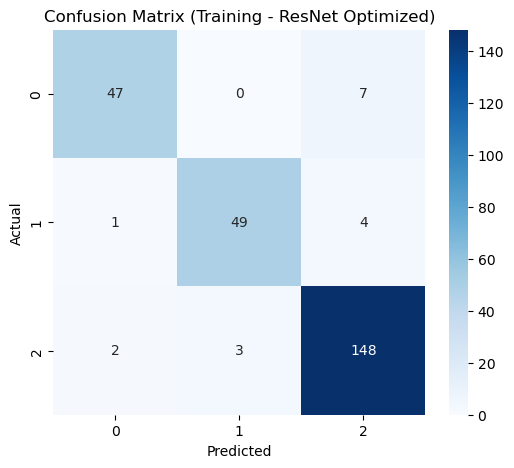


=== 🚀 Testing Performance ===
Testing Accuracy: 0.9115

Testing Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85        23
           1       0.81      0.88      0.84        24
           2       0.98      0.94      0.96        66

    accuracy                           0.91       113
   macro avg       0.88      0.89      0.88       113
weighted avg       0.92      0.91      0.91       113



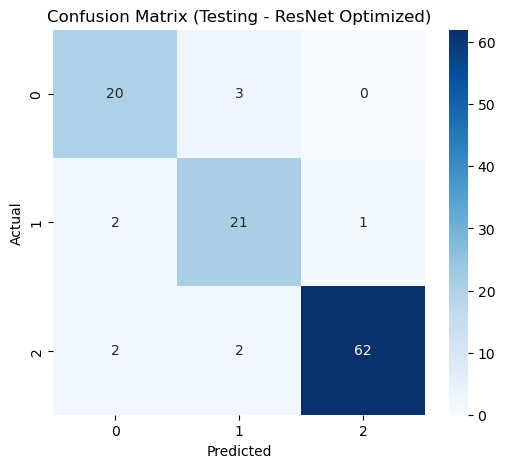

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

# Load dataset
data = pd.read_csv(r"updated_data.csv")

# Encode categorical variables
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Encode target variable
le_target = LabelEncoder()
data['Sleep Disorder'] = le_target.fit_transform(data['Sleep Disorder'])

# Train-test split
X = data.drop(columns=['Sleep Disorder'])
y = data['Sleep Disorder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Feature Mapping (Polynomial Features)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_mapped = poly.fit_transform(X_train)
X_test_mapped = poly.transform(X_test)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_mapped)
X_test_scaled = scaler.transform(X_test_mapped)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

class ResNetBlock(nn.Module):
    """Optimized Residual Block with Dropout, Batch Normalization, and L1 Regularization"""
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.3):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        self.bn2 = nn.BatchNorm1d(input_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x  # Skip connection
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out += identity  # Add skip connection
        out = self.relu(out)
        return out

class ResNetOptimizedL1FM(nn.Module):
    """ResNet with Optimizations: Feature Mapping, Dropout, BatchNorm, Hyperparameter Tuning, and L1 Regularization"""
    def __init__(self, input_dim, num_classes, dropout_rate, l1_lambda):
        super(ResNetOptimizedL1FM, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.resblock1 = ResNetBlock(64, 128, dropout_rate)
        self.resblock2 = ResNetBlock(64, 128, dropout_rate)
        self.fc2 = nn.Linear(64, num_classes)
        self.l1_lambda = l1_lambda  # L1 Regularization Strength
        self.init_weights()  # Apply Xavier Initialization

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.fc2(x)
        return x

    def init_weights(self):
        """Apply Xavier initialization to layers"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def l1_regularization(self):
        """Compute L1 regularization loss"""
        l1_norm = sum(torch.norm(param, 1) for param in self.parameters())
        return self.l1_lambda * l1_norm

def objective(trial):
    """Objective function for hyperparameter tuning"""
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 0.0001, 0.01, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    l1_lambda = trial.suggest_float("l1_lambda", 1e-5, 1e-2, log=True)  # L1 Regularization Strength

    # Define model
    model = ResNetOptimizedL1FM(input_dim=X_train_mapped.shape[1], num_classes=len(y.unique()), dropout_rate=dropout_rate, l1_lambda=l1_lambda)

    # Loss, Optimizer, and Learning Rate Scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Create DataLoader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training
    epochs = 20
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch) + model.l1_regularization()  # Add L1 loss
            loss.backward()
            optimizer.step()
        scheduler.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).argmax(dim=1).numpy()
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("Best Hyperparameters:", best_params)

final_model = ResNetOptimizedL1FM(input_dim=X_train_mapped.shape[1], num_classes=len(y.unique()), dropout_rate=best_params["dropout_rate"], l1_lambda=best_params["l1_lambda"])

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params["learning_rate"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=best_params["batch_size"], shuffle=True)

# Training
epochs = 50
for epoch in range(epochs):
    final_model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = final_model(X_batch)
        loss = criterion(outputs, y_batch) + final_model.l1_regularization()  # L1 Loss
        loss.backward()
        optimizer.step()
    scheduler.step()


final_model.eval()

# Training Predictions
with torch.no_grad():
    y_train_pred = final_model(X_train_tensor).argmax(dim=1).numpy()

# Testing Predictions
with torch.no_grad():
    y_test_pred = final_model(X_test_tensor).argmax(dim=1).numpy()


train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)
train_conf_matrix = confusion_matrix(y_train, y_train_pred)

print("\n=== 🚀 Training Performance ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print("\nTraining Classification Report:\n", train_report)

# Training Confusion Matrix - Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Training - ResNet Optimized)')
plt.show()

test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n=== 🚀 Testing Performance ===")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print("\nTesting Classification Report:\n", test_report)

# Testing Confusion Matrix - Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_target.classes_, yticklabels=le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Testing - ResNet Optimized)')
plt.show()

In [32]:
def analyze_sleep_disorder_factors(model, data, X_tensor, poly, scaler, le_target, user_profile=None):
    import pandas as pd
    import numpy as np
    import torch
    import matplotlib.pyplot as plt
    import seaborn as sns

    print("\n=== 😴 Sleep Disorder Risk Factor Impact Analysis ===")

    features = [col for col in data.columns if col != 'Sleep Disorder']

    intervention_impacts = {
        'Stress Level': -1.0,
        'Physical Activity Level': 1.0,
        'Screen Time Before Bed': -0.5,
        'Caffeine Intake': -50,
        'Alcohol Use': -1.0,
        'BMI': -2.0,
        'Smoking Status': -0.5
    }

    if user_profile is not None:
        baseline_profile = user_profile[features].copy()
    else:
        baseline_profile = data[features].mean().copy()

    intervention_profile = baseline_profile.copy()
    for feature, impact in intervention_impacts.items():
        if feature in intervention_profile.index:
            intervention_profile[feature] += impact
            if feature == 'Stress Level':
                intervention_profile[feature] = max(1, intervention_profile[feature])
            elif feature == 'Physical Activity Level':
                intervention_profile[feature] = min(5, intervention_profile[feature])
            elif feature == 'BMI':
                intervention_profile[feature] = max(10, intervention_profile[feature])

    print("\nBaseline vs Post-Intervention Profile:")
    for feature, impact in intervention_impacts.items():
        if feature in baseline_profile.index:
            print(f"{feature}: {baseline_profile[feature]:.2f} → {intervention_profile[feature]:.2f} (Change: {impact:+.2f})")

    profiles_df = pd.DataFrame([baseline_profile, intervention_profile])
    mapped = poly.transform(profiles_df)
    scaled = scaler.transform(mapped)
    tensor = torch.tensor(scaled, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1).numpy()

    disorder_labels = le_target.classes_
    prob_df = pd.DataFrame(probs, columns=disorder_labels)

    print("\nPredicted Sleep Disorder Probabilities:")
    print("\nBaseline Profile:")
    for disorder, prob in prob_df.iloc[0].items():
        print(f"  - {disorder}: {prob:.2%}")

    print("\nPost-Intervention Profile:")
    for disorder, prob in prob_df.iloc[1].items():
        print(f"  - {disorder}: {prob:.2%}")

    prob_change = prob_df.iloc[1] - prob_df.iloc[0]

    print("\nPredicted Impact of Interventions on Sleep Disorders:")
    change_summary = pd.DataFrame({
        'Disorder': disorder_labels,
        'Baseline': prob_df.iloc[0],
        'Intervention': prob_df.iloc[1],
        'Change': prob_change
    })
    change_summary['Direction'] = change_summary['Change'].apply(lambda x: '↑' if x > 0 else '↓')
    change_summary['Change(%)'] = change_summary['Change'].apply(lambda x: f"{abs(x)*100:.2f}%")
    print(change_summary[['Disorder', 'Baseline', 'Intervention', 'Change(%)', 'Direction']])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Disorder', y='Change', data=change_summary, palette='coolwarm', hue='Direction', dodge=False)
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Change in Sleep Disorder Probability After Interventions')
    plt.ylabel('Probability Change')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Effect of Stress Level on Sleep Disorder Probabilities
    stress_range = np.linspace(1, 10, 10)
    stress_profiles = [baseline_profile.copy() for _ in stress_range]
    for profile, level in zip(stress_profiles, stress_range):
        profile['Stress Level'] = level

    stress_df = pd.DataFrame(stress_profiles)
    mapped_stress = poly.transform(stress_df)
    scaled_stress = scaler.transform(mapped_stress)
    tensor_stress = torch.tensor(scaled_stress, dtype=torch.float32)

    with torch.no_grad():
        logits_stress = model(tensor_stress)
        probs_stress = torch.softmax(logits_stress, dim=1).numpy()

    plt.figure(figsize=(10, 6))
    for i, disorder in enumerate(disorder_labels):
        plt.plot(stress_range, probs_stress[:, i], label=disorder)

    plt.title("Effect of Stress Level on Sleep Disorder Probabilities")
    plt.xlabel("Stress Level")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Impact of sleep quality bar chart
    sleep_quality_impact = []
    for feature in intervention_impacts.keys():
        sleep_quality_impact.append({
            'Feature': feature,
            'Impact': abs(intervention_impacts[feature])
        })
    impact_df = pd.DataFrame(sleep_quality_impact)
    impact_df.sort_values('Impact', ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Impact', y='Feature', data=impact_df, palette='viridis')
    plt.title("Impact of Sleep Quality Associated Features")
    plt.xlabel("Estimated Impact Magnitude")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return prob_df, prob_change


=== 😴 Sleep Disorder Risk Factor Impact Analysis ===

Baseline vs Post-Intervention Profile:
Stress Level: 5.39 → 4.39 (Change: -1.00)
Physical Activity Level: 59.17 → 5.00 (Change: +1.00)

Predicted Sleep Disorder Probabilities:

Baseline Profile:
  - 0: 16.22%
  - 1: 5.13%
  - 2: 78.65%

Post-Intervention Profile:
  - 0: 62.67%
  - 1: 3.39%
  - 2: 33.94%

Predicted Impact of Interventions on Sleep Disorders:
   Disorder  Baseline  Intervention Change(%) Direction
0         0  0.162188      0.626747    46.46%         ↑
1         1  0.051327      0.033871     1.75%         ↓
2         2  0.786484      0.339383    44.71%         ↓


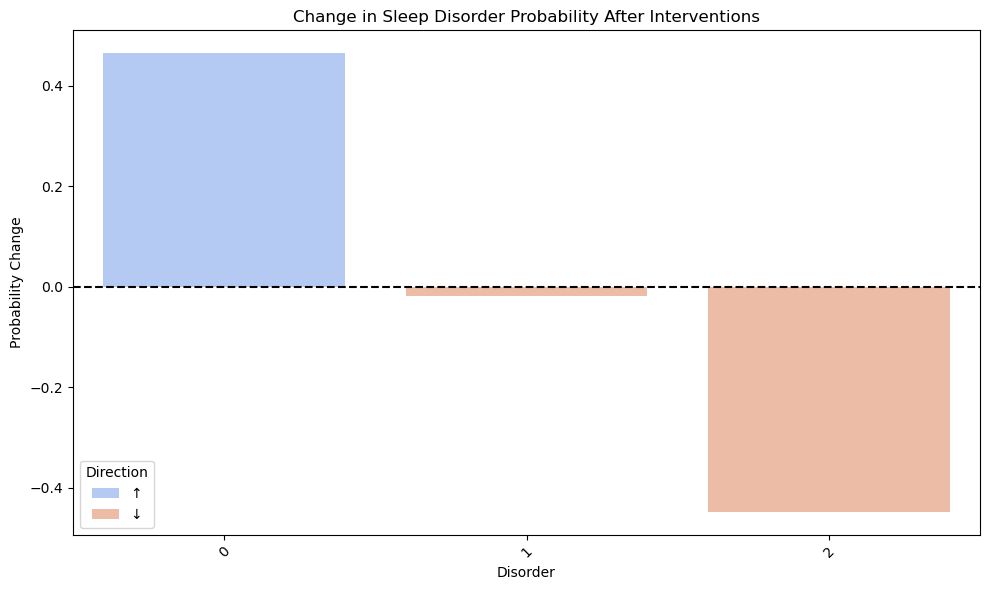

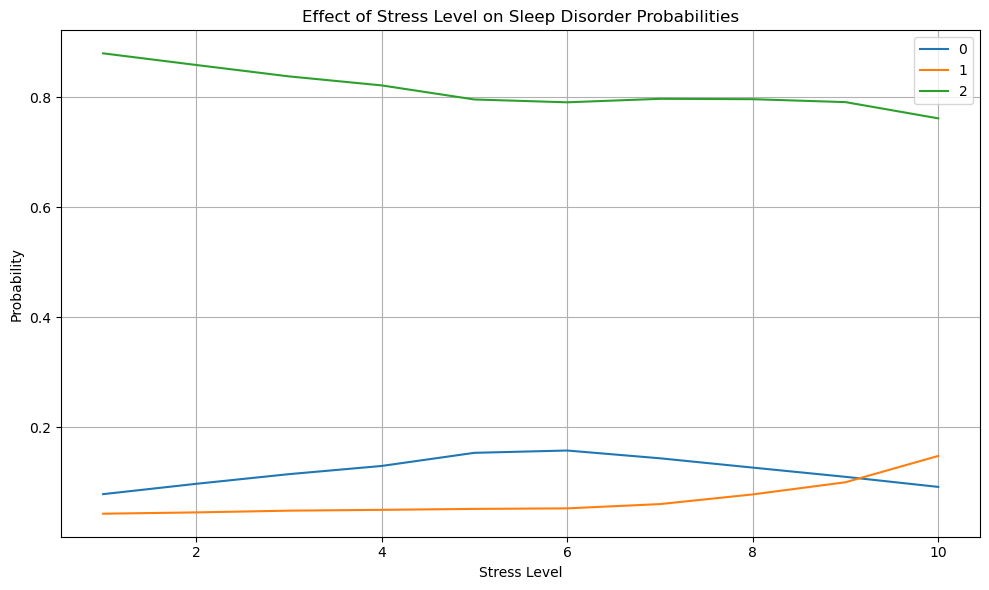

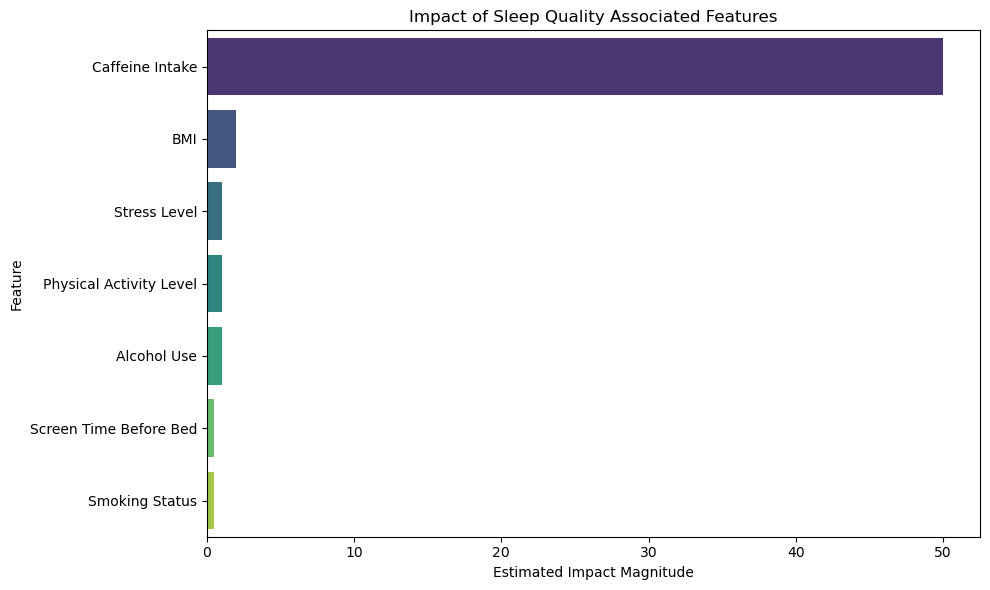

In [33]:
all_prob_df, prob_change = analyze_sleep_disorder_factors(final_model, data, X_test_tensor, poly, scaler, le_target)


=== 😴 Sleep Disorder Risk Factor Impact Analysis ===

Baseline vs Post-Intervention Profile:
Stress Level: 5.39 → 4.39 (Change: -1.00)
Physical Activity Level: 59.17 → 5.00 (Change: +1.00)

Predicted Sleep Disorder Probabilities:

Baseline Profile:
  - 0: 5.83%
  - 1: 2.23%
  - 2: 91.93%

Post-Intervention Profile:
  - 0: 57.62%
  - 1: 4.14%
  - 2: 38.23%

Predicted Impact of Interventions on Sleep Disorders:
   Disorder  Baseline  Intervention Change(%) Direction
0         0  0.058343      0.576248    51.79%         ↑
1         1  0.022347      0.041407     1.91%         ↑
2         2  0.919311      0.382345    53.70%         ↓


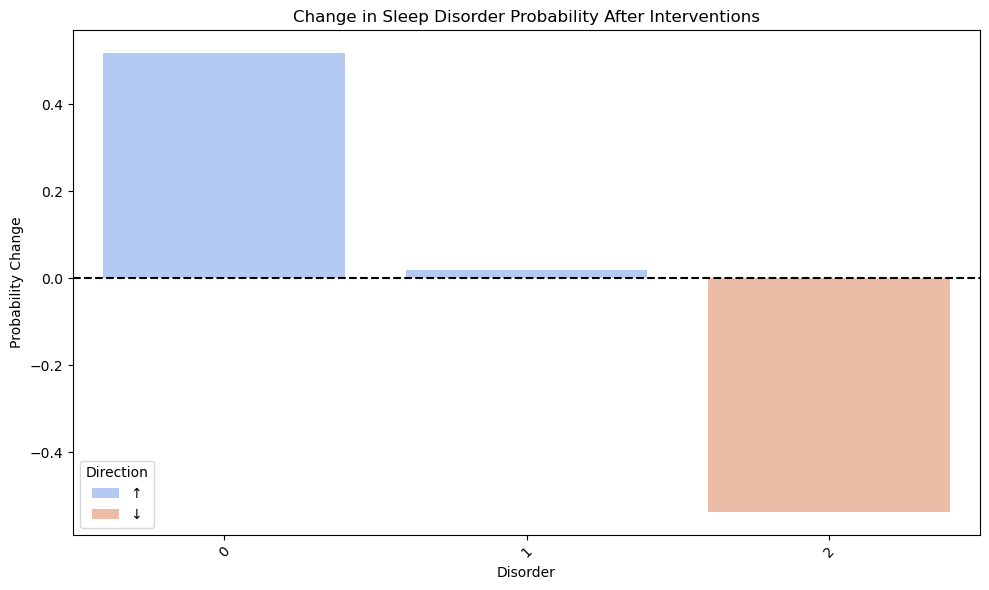

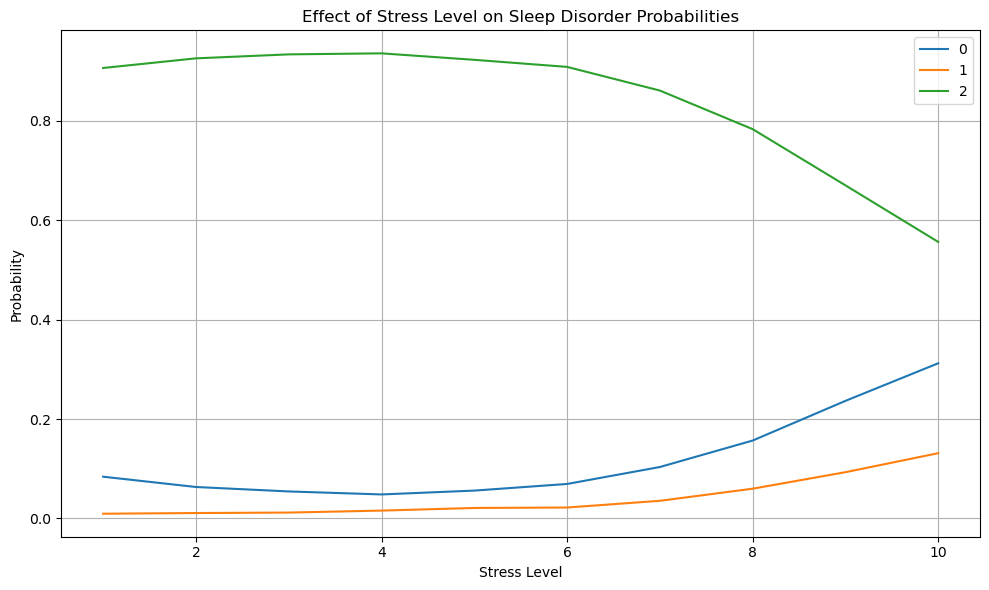

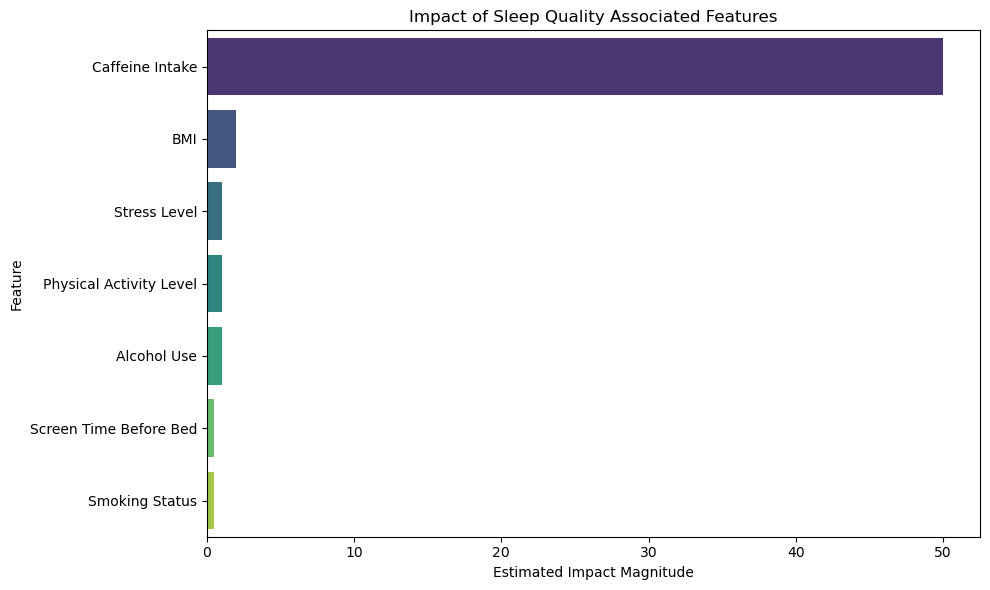